In [4]:
# ==================== Cell 1: Setup & Imports ====================

# Install necessary libraries if not already present in the environment
# - yfinance: For downloading stock data (used in initial data acquisition, not needed if loading from CSV)
# - torch: PyTorch library for deep learning models and operations
# - numpy: Fundamental package for numerical computation
# - pandas: Library for data manipulation and analysis
# - matplotlib: Library for plotting graphs
# - stable-baselines3: Popular library for RL algorithms (though we implement PPO/DDPG manually here)
# - gymnasium: Successor to OpenAI Gym, provides standard RL environment interface
!pip install yfinance torch numpy pandas matplotlib stable-baselines3 gymnasium --quiet

# Standard library imports
import time
import random
from collections import deque, namedtuple
import copy
import math
import os # Optional: For file path operations if needed

# Third-party library imports
import yfinance as yf # Import even if loading from CSV, might be useful for other checks
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical, Normal
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt

# --- Device Configuration ---
# Set the device for PyTorch computations (use GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using PyTorch device: {device}")

# --- Reproducibility (Optional) ---
# Uncomment the following lines to set random seeds for potentially
# more reproducible results. Note that full reproducibility on GPUs
# can sometimes be tricky.
# seed = 42
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed) # for multi-GPU.
#     # These settings can slightly slow down training but increase reproducibility
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

print("Cell 1: Setup and Imports completed.")

Using PyTorch device: cuda
Cell 1: Setup and Imports completed.


In [5]:
# ==================== Cell 2: Configuration ====================
# Description: Define hyperparameters, environment settings, paths,
#              and model configurations based on the research paper
#              and the specific dataset being used.

print("Setting up configuration based on paper specifications...")

# --- Environment & Data Config ---
# !! IMPORTANT !! Ensure these tickers match the ones available after running Cell 3
# This list might be dynamically updated in Cell 3 if some tickers are missing.
# Define the initial list based on your target stocks loaded in Cell 3.
STOCK_TICKERS_INITIAL = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META'] # Adjust as per your loaded data

# !! IMPORTANT !! Update these paths to your uploaded CSV files
TRAIN_CSV_PATH = "/content/merged_data.csv"      # Path to your training data CSV
TRADE_CSV_PATH = "/content/merged_data_2015.csv" # Path to your evaluation data CSV

# Portfolio Parameters (from Paper Section 4.2)
INITIAL_BALANCE = 1_000_000      # Starting cash balance for trading
TRANSACTION_COST_PCT = 0.001     # Transaction cost as a percentage (0.1%)
HMAX = 100                       # Maximum number of shares per stock per trade (LLC action constraint)

# HLC State Feature Configuration
# ** CRITICAL NOTE **: The paper uses advanced features:
#   1. Predicted forward returns (f_r) from a Transformer model.
#   2. Sentiment scores (ss) from FinGPT.
# Implementing these requires separate model training and data pipelines.
# The code below uses placeholder technical indicators calculated in Cell 3.
# Ensure this list EXACTLY matches the HLC_FEATURE_COLS list in Cell 3's preprocess_data_custom function.
HLC_FEATURE_COLS = [
    'ROC5',   # Example: Rate of Change 5 days
    'MA5',    # Example: Moving Average 5 days (relative might be better)
    'STD5',   # Example: Standard Deviation 5 days
    'VOLUME_REL_MA20', # Example: Volume relative to 20-day MA
    'RSI14'   # Example: Relative Strength Index 14 days
]
HLC_STATE_FEATURES = len(HLC_FEATURE_COLS) # Number of features per stock for HLC state

# --- PPO (HLC) Hyperparameters (from Paper Section 4.2 & Algorithm 1) ---
HLC_LEARNING_RATE = 3e-4         # Learning rate for PPO Actor and Critic (Section 4.2)
HLC_GAMMA = 0.99                 # Discount factor (Section 4.2)
HLC_CLIP_EPSILON = 0.2           # PPO clipping parameter 'epsilon' (Section 4.2)
# -- Unspecified PPO params (using common defaults, potentially require tuning) --
HLC_GAE_LAMBDA = 0.95            # Generalized Advantage Estimation lambda (Default: 0.95)
HLC_ENTROPY_COEF = 0.01          # Entropy coefficient for exploration bonus (Default: 0.01)
HLC_VALUE_LOSS_COEF = 0.5        # Coefficient for the value function loss (Default: 0.5)
HLC_UPDATE_EPOCHS = 10           # Number of optimization epochs per PPO update 'P' (Default: 10)
HLC_BATCH_SIZE = 256             # Batch size for PPO updates (Section 4.2)
HLC_TRAJECTORY_SIZE = 2048       # Number of steps (transitions) collected before each PPO update (Default: 2048)

# --- DDPG (LLC) Hyperparameters (from Paper Section 4.2 & Algorithm 2) ---
LLC_LEARNING_RATE_ACTOR = 1e-3   # Actor learning rate (Section 4.2 - states 1e-3 for both)
LLC_LEARNING_RATE_CRITIC = 1e-3  # Critic learning rate (Section 4.2 - states 1e-3 for both)
LLC_GAMMA = 0.99                 # Discount factor (Section 4.2)
LLC_TAU = 0.005                  # Soft update parameter 'tau' for target networks (Section 4.2)
LLC_BATCH_SIZE = 256             # Batch size for DDPG updates (Section 4.2)
LLC_BUFFER_SIZE = int(2e5)       # Replay buffer capacity 'R' (Section 4.2)
# -- Unspecified DDPG params --
LLC_ACTION_NOISE_STD = 0.1       # Standard deviation for Gaussian exploration noise 'N' (Default: 0.1)

# --- Phased Training Hyperparameters (Based on Algorithm 3 & Section 4.2) ---
# Total training duration is controlled by MAX_TOTAL_STEPS, matching paper's 5e5.
# TOTAL_ITERATIONS controls the number of full data passes (episodes) *if* MAX_TOTAL_STEPS isn't hit first.
# Setting a reasonable number like 300 allows phases to be defined but step limit is primary control.
TOTAL_ITERATIONS = 300           # Max number of outer loops (episodes/data passes) 'M'
MAX_TOTAL_STEPS = int(5e5)       # Maximum total environment steps for training (Section 4.2)

# Define phase durations based on iterations (can be adjusted)
PHASE1_END_ITER = int(0.10 * TOTAL_ITERATIONS) # Approx. 10% iterations for Phase 1 (HLC only)
PHASE2_END_ITER = int(0.20 * TOTAL_ITERATIONS) # Approx. next 10% for Phase 2 (LLC only)
# Phase 3 runs from PHASE2_END_ITER + 1 until TOTAL_ITERATIONS or MAX_TOTAL_STEPS

# Alpha decay for HLC reward combination weight (Paper Section 3.2)
ALPHA_0 = 1.0                    # Initial value for alpha_t
ALPHA_LAMBDA = 0.001             # Exponential decay rate 'lambda'

# --- Derived Configurations (Initialized here, may be updated in Cell 3) ---
NUM_STOCKS = len(STOCK_TICKERS_INITIAL) # Initial number of stocks
HLC_ACTION_DIM = 3               # HLC actions: Buy (+1), Hold (0), Sell (-1)
LLC_ACTION_DIM = NUM_STOCKS      # LLC actions: Continuous volume per stock [-1, 1]
LLC_STATE_DIM = 1 + NUM_STOCKS + NUM_STOCKS + NUM_STOCKS # balance, prices, holdings, hlc_actions

print("--- Configuration Summary ---")
print(f"Initial Tickers: {STOCK_TICKERS_INITIAL} (Count: {NUM_STOCKS})")
print(f"Portfolio: Initial Balance=${INITIAL_BALANCE:,.0f}, Transaction Cost={TRANSACTION_COST_PCT*100:.2f}%")
print(f"HLC State Features: {HLC_STATE_FEATURES} ({', '.join(HLC_FEATURE_COLS)})")
print(f"HLC (PPO): LR={HLC_LEARNING_RATE}, Clip={HLC_CLIP_EPSILON}, Batch={HLC_BATCH_SIZE}, Trajectory={HLC_TRAJECTORY_SIZE}")
print(f"LLC (DDPG): LR Actor={LLC_LEARNING_RATE_ACTOR}, LR Critic={LLC_LEARNING_RATE_CRITIC}, Tau={LLC_TAU}, Buffer={LLC_BUFFER_SIZE:,}, Batch={LLC_BATCH_SIZE}")
print(f"Training: Max Steps={MAX_TOTAL_STEPS:,}, Max Iterations={TOTAL_ITERATIONS}, Phase1 End={PHASE1_END_ITER}, Phase2 End={PHASE2_END_ITER}")
print(f"Alpha Decay: Alpha_0={ALPHA_0}, Lambda={ALPHA_LAMBDA}")
print(f"LLC State Dimension (Initial): {LLC_STATE_DIM}")
print("-" * 27)
print("Cell 2: Configuration setup completed.")

# Define placeholder variables that will be populated in Cell 3
# This helps prevent NameErrors if cells are run out of order later
hlc_states_train, close_prices_train, open_prices_train, dates_train, tickers_train = (None,) * 5
hlc_states_trade, close_prices_trade, open_prices_trade, dates_trade, tickers_trade = (None,) * 5
hlc_state_normalizer, balance_normalizer, price_normalizer, holdings_normalizer = (None,) * 4

Setting up configuration based on paper specifications...
--- Configuration Summary ---
Initial Tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META'] (Count: 5)
Portfolio: Initial Balance=$1,000,000, Transaction Cost=0.10%
HLC State Features: 5 (ROC5, MA5, STD5, VOLUME_REL_MA20, RSI14)
HLC (PPO): LR=0.0003, Clip=0.2, Batch=256, Trajectory=2048
LLC (DDPG): LR Actor=0.001, LR Critic=0.001, Tau=0.005, Buffer=200,000, Batch=256
Training: Max Steps=500,000, Max Iterations=300, Phase1 End=30, Phase2 End=60
Alpha Decay: Alpha_0=1.0, Lambda=0.001
LLC State Dimension (Initial): 16
---------------------------
Cell 2: Configuration setup completed.


In [6]:
# ========== Use this code in Colab Cell 3 ==========
import time
import pandas as pd
import numpy as np
# import yfinance as yf # No longer needed

# --- Configuration (ensure these match your needs and data) ---
# Define the tickers PRESENT IN YOUR CSV FILES
STOCK_TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META'] # Must match 'instrument' column values you intend to use
TRAIN_CSV_PATH = "/content/train_data.csv" # MAKE SURE this is the correct path/name of your uploaded training CSV
TRADE_CSV_PATH = "/content/test_data.csv" # MAKE SURE this is the correct path/name of your uploaded trading CSV

INITIAL_BALANCE = 1_000_000
TRANSACTION_COST_PCT = 0.001
HMAX = 100

# HLC State Feature Selection: Choose features from your CSV for the HLC state
# The paper used predicted returns and sentiment. Let's select some relevant-looking technical indicators from your CSV.
# You MUST select exactly HLC_STATE_FEATURES columns here.
HLC_FEATURE_COLS = [
    'ROC5',   # Rate of Change 5 days
    'MA5',    # Moving Average 5 days (relative to close might be better if available, e.g., close/MA5 - 1)
    'STD5',   # Standard Deviation 5 days
    'VOLUME_REL_MA20', # We'll calculate relative volume below
    'RSI14' # We'll calculate RSI below (or use a sentiment column if available)
]
HLC_STATE_FEATURES = len(HLC_FEATURE_COLS) # Set this based on the columns selected
LOOKBACK_WINDOW = 10 # This might be less relevant if features are already time-aggregated, but keep for potential future use

NUM_STOCKS = len(STOCK_TICKERS)
# --- End Config ---

# --- Load Data from Uploaded CSVs ---
try:
    print(f"Loading training data from {TRAIN_CSV_PATH}...")
    raw_data_train_full = pd.read_csv(TRAIN_CSV_PATH, parse_dates=['datetime'], index_col='datetime')
    print(f"Loading trading data from {TRADE_CSV_PATH}...")
    raw_data_trade_full = pd.read_csv(TRADE_CSV_PATH, parse_dates=['datetime'], index_col='datetime')
    print("CSV files loaded successfully.")

    # --- Filter Data for Selected Tickers ---
    raw_data_train = raw_data_train_full[raw_data_train_full['instrument'].isin(STOCK_TICKERS)].copy()
    raw_data_trade = raw_data_trade_full[raw_data_trade_full['instrument'].isin(STOCK_TICKERS)].copy()

    if raw_data_train.empty or raw_data_trade.empty:
        print("\nERROR: No data found for the specified STOCK_TICKERS in the loaded CSV files.")
        print(f"Tickers specified: {STOCK_TICKERS}")
        print(f"Tickers available in train CSV: {raw_data_train_full['instrument'].unique()}")
        raise SystemExit("Data for specified tickers not found in CSVs.")

    print(f"Data filtered for tickers: {STOCK_TICKERS}")

except FileNotFoundError:
    print("\n" + "="*30)
    print(f"ERROR: CSV file not found. Please ensure '{TRAIN_CSV_PATH}' and '{TRADE_CSV_PATH}' are uploaded correctly.")
    print("="*30 + "\n")
    raise SystemExit("Missing required CSV data.")
except Exception as e:
    print(f"\nAn error occurred loading or processing the CSV files: {e}")
    print("Please check the format and content of the uploaded CSV files.")
    raise SystemExit("Error loading CSV data.")


# --- Preprocessing Function (Adapted for the new CSV format) ---
def preprocess_data_custom(df_full, tickers, hlc_feature_cols):
    """
    Preprocesses data loaded from the custom CSV format.
    Extracts OHLCV, calculates required HLC features, and pivots data.
    """
    required_cols = ['instrument', 'open', 'high', 'low', 'close', 'volume'] + hlc_feature_cols
    missing_cols = [col for col in required_cols if col not in df_full.columns and col not in ['VOLUME_REL_MA20', 'RSI14']] # Allow calculated feats
    if missing_cols:
        print(f"ERROR: The loaded CSV is missing required columns: {missing_cols}")
        raise ValueError(f"Missing columns in CSV: {missing_cols}")

    # Pivot the table to have dates as index and multi-level columns (Ticker, Feature)
    # Start with essential columns
    ohlcv_data = df_full[['instrument', 'open', 'high', 'low', 'close', 'volume']].copy()
    ohlcv_pivot = ohlcv_data.pivot(columns='instrument')
    ohlcv_pivot.columns = ohlcv_pivot.columns.swaplevel(0, 1) # Make ticker the outer level
    ohlcv_pivot.sort_index(axis=1, level=0, inplace=True)

    # Ensure all selected tickers are present after pivot
    missing_tickers = [t for t in tickers if t not in ohlcv_pivot.columns.levels[0]]
    if missing_tickers:
         print(f"Warning: Data for tickers {missing_tickers} not found after pivoting. They might be missing in the CSV for some dates.")
         # Handle missing tickers - either drop them from tickers list or fill later
         # For now, let's assume we proceed only with available tickers if this happens
         tickers = [t for t in tickers if t in ohlcv_pivot.columns.levels[0]]
         print(f"Proceeding with available tickers: {tickers}")
         if not tickers:
             raise ValueError("No data available for any selected ticker after pivoting.")


    # Extract Open and Close prices aligned with dates
    # Important: Ensure the columns exist AFTER pivoting
    try:
        close_prices = ohlcv_pivot.loc[:, (tickers, 'close')].values
        open_prices = ohlcv_pivot.loc[:, (tickers, 'open')].values
        dates = ohlcv_pivot.index
    except KeyError as e:
        print(f"Error accessing pivoted columns: {e}. Check if 'open'/'close' exist for all tickers.")
        print("Available columns after pivot:", ohlcv_pivot.columns)
        raise

    num_stocks = len(tickers)
    num_timesteps = len(dates)
    hlc_states_all = np.zeros((num_timesteps, num_stocks, HLC_STATE_FEATURES))

    # Calculate/Extract HLC features for each ticker
    print("Calculating/Extracting HLC features...")
    for i, ticker in enumerate(tickers):
        ticker_data = df_full[df_full['instrument'] == ticker].reindex(dates).copy() # Ensure alignment with pivoted index

        feature_values = []
        for feature_name in hlc_feature_cols:
            if feature_name == 'VOLUME_REL_MA20':
                # Calculate Volume relative to its 20-day MA
                vol_ma20 = ticker_data['volume'].rolling(window=20, min_periods=1).mean()
                rel_vol = ticker_data['volume'] / vol_ma20.replace(0, 1e-6) # Avoid division by zero
                feature_values.append(rel_vol.fillna(1.0)) # Fill initial NaNs with 1 (neutral)
            elif feature_name == 'RSI14':
                 # Calculate RSI(14)
                 close_series = ticker_data['close']
                 delta = close_series.diff()
                 gain = (delta.where(delta > 0, 0)).rolling(window=min(14, len(close_series)), min_periods=1).mean()
                 loss = (-delta.where(delta < 0, 0)).rolling(window=min(14, len(close_series)), min_periods=1).mean()
                 rs = gain / loss.replace(0, 1e-6) # Avoid division by zero
                 rsi = 100 - (100 / (1 + rs))
                 feature_values.append(rsi.fillna(50)) # Fill initial NaNs with 50 (neutral)
            elif feature_name in ticker_data.columns:
                feature_values.append(ticker_data[feature_name])
            else:
                print(f"Warning: Requested HLC feature '{feature_name}' not found for {ticker}. Filling with zeros.")
                feature_values.append(pd.Series(np.zeros(num_timesteps), index=dates))

        # Combine features for the ticker, fill NaNs, and assign
        ticker_features_df = pd.concat(feature_values, axis=1)
        ticker_features_filled = ticker_features_df.ffill().bfill().values
        ticker_features_final = np.nan_to_num(ticker_features_filled) # Final NaN check

        if ticker_features_final.shape[1] != HLC_STATE_FEATURES:
             print(f"CRITICAL ERROR: Feature dimension mismatch for {ticker}. Expected {HLC_STATE_FEATURES}, got {ticker_features_final.shape[1]}. Check HLC_FEATURE_COLS.")
             # Attempt to fix shape (less ideal)
             if ticker_features_final.shape[1] < HLC_STATE_FEATURES:
                 padding = np.zeros((num_timesteps, HLC_STATE_FEATURES - ticker_features_final.shape[1]))
                 ticker_features_final = np.hstack((ticker_features_final, padding))
             else:
                 ticker_features_final = ticker_features_final[:, :HLC_STATE_FEATURES]

        if ticker_features_final.shape[0] != num_timesteps:
             print(f"CRITICAL ERROR: Timestep mismatch for {ticker}. Expected {num_timesteps}, got {ticker_features_final.shape[0]}. Check data alignment.")
             # This often indicates issues with reindexing or pivoting
             # Attempting a simple fix by reindexing again (might hide underlying issues)
             temp_df = pd.DataFrame(ticker_features_final, index=ticker_data.index)
             ticker_features_final = temp_df.reindex(dates).ffill().bfill().values
             if ticker_features_final.shape[0] != num_timesteps: # Check again
                 raise ValueError(f"Cannot align features for {ticker} to the correct number of timesteps.")


        hlc_states_all[:, i, :] = ticker_features_final

    print("HLC features processing complete.")
    return hlc_states_all, close_prices, open_prices, dates, tickers # Return potentially modified tickers list


# --- Preprocess Loaded Data ---
print("\nPreprocessing loaded data...")
# Pass the original list of tickers, the function will adjust if some are missing
hlc_states_train, close_prices_train, open_prices_train, dates_train, tickers_train = preprocess_data_custom(raw_data_train, STOCK_TICKERS, HLC_FEATURE_COLS)
hlc_states_trade, close_prices_trade, open_prices_trade, dates_trade, tickers_trade = preprocess_data_custom(raw_data_trade, STOCK_TICKERS, HLC_FEATURE_COLS)

# *** IMPORTANT: Update NUM_STOCKS if tickers were dropped ***
if len(tickers_train) != NUM_STOCKS or len(tickers_trade) != NUM_STOCKS:
    print("Warning: Number of available tickers changed during preprocessing.")
    # Use the tickers available in the training set for consistency
    STOCK_TICKERS = tickers_train
    NUM_STOCKS = len(STOCK_TICKERS)
    print(f"Updated NUM_STOCKS to: {NUM_STOCKS}")
    print(f"Using tickers: {STOCK_TICKERS}")
    # Ensure trade data also aligns (might need re-filtering if different tickers were dropped)
    if tickers_trade != tickers_train:
         print("Re-processing trade data to match training tickers...")
         hlc_states_trade, close_prices_trade, open_prices_trade, dates_trade, _ = preprocess_data_custom(raw_data_trade, STOCK_TICKERS, HLC_FEATURE_COLS)


print("Data Preprocessed.")
print("Training HLC States Shape:", hlc_states_train.shape)
print("Trading HLC States Shape:", hlc_states_trade.shape)
print("Training Close Prices Shape:", close_prices_train.shape)
print("Trading Close Prices Shape:", close_prices_trade.shape)

# --- Normalization Setup (Keep robust RunningMeanStd class) ---
if hlc_states_train.shape[0] > 0 and close_prices_train.shape[0] > 0 and NUM_STOCKS > 0:
    class RunningMeanStd:
        # ... (keep the robust RunningMeanStd class definition) ...
        def __init__(self, epsilon=1e-4, shape=()):
            self.mean = np.zeros(shape, 'float64')
            self.var = np.ones(shape, 'float64')
            self.count = epsilon
        def update(self, x):
            if x.size == 0 : return
            x_clean = np.nan_to_num(x.astype('float64'))
            batch_mean = np.mean(x_clean, axis=0)
            batch_var = np.var(x_clean, axis=0)
            batch_count = x.shape[0]
            self.update_from_moments(batch_mean, batch_var, batch_count)
        def update_from_moments(self, batch_mean, batch_var, batch_count):
             if batch_count == 0: return
             delta = batch_mean - self.mean
             tot_count = self.count + batch_count
             new_mean = self.mean + delta * batch_count / tot_count
             m_a = self.var * self.count
             m_b = batch_var * batch_count
             M2 = m_a + m_b + np.square(delta) * self.count * batch_count / tot_count
             new_var = M2 / tot_count
             new_count = tot_count
             self.mean = new_mean; self.var = new_var; self.count = new_count

    hlc_state_reshaped = hlc_states_train.reshape(-1, HLC_STATE_FEATURES)
    hlc_state_normalizer = RunningMeanStd(shape=(HLC_STATE_FEATURES,))
    hlc_state_normalizer.update(hlc_state_reshaped)

    balance_normalizer = RunningMeanStd(shape=(1,))
    price_normalizer = RunningMeanStd(shape=(NUM_STOCKS,))
    holdings_normalizer = RunningMeanStd(shape=(NUM_STOCKS,))

    balance_normalizer.update(np.array([[INITIAL_BALANCE]]))
    price_normalizer.update(close_prices_train)
    # Estimate holdings variance robustly
    mean_prices = np.nanmean(close_prices_train, axis=0)
    std_prices = np.nanstd(close_prices_train, axis=0)
    # Avoid division by zero if mean price is somehow zero
    safe_mean_prices = np.where(mean_prices == 0, 1e-6, mean_prices)
    estimated_holdings_variance = (std_prices * (INITIAL_BALANCE / NUM_STOCKS / safe_mean_prices))**2
    holdings_normalizer.update_from_moments(np.zeros(NUM_STOCKS), np.nan_to_num(estimated_holdings_variance), close_prices_train.shape[0])
    print("Normalizers fitted on training data.")
else:
    print("ERROR: Training data is empty or has zero stocks after preprocessing. Cannot fit normalizers.")
    raise SystemExit("Cannot proceed without valid training data for normalization.")


# --- Normalization Functions (Keep robust versions) ---
def normalize_hlc_state(state, normalizer):
    # ... (keep the robust normalize_hlc_state function) ...
    state_clean = np.nan_to_num(state)
    original_shape = state_clean.shape
    state_reshaped = state_clean.reshape(-1, HLC_STATE_FEATURES)
    normalized_reshaped = (state_reshaped - normalizer.mean) / np.sqrt(normalizer.var + 1e-8)
    return normalized_reshaped.reshape(original_shape)

def normalize_llc_state(balance, prices, holdings, hlc_action, b_norm, p_norm, h_norm):
    # ... (keep the robust normalize_llc_state function) ...
    balance_clean = np.nan_to_num(balance)
    prices_clean = np.nan_to_num(prices)
    holdings_clean = np.nan_to_num(holdings)
    hlc_action_clean = np.nan_to_num(hlc_action)
    norm_b = (np.array([balance_clean]) - b_norm.mean) / np.sqrt(b_norm.var + 1e-8)
    norm_p = (prices_clean - p_norm.mean) / np.sqrt(p_norm.var + 1e-8)
    norm_h = (holdings_clean - h_norm.mean) / np.sqrt(h_norm.var + 1e-8)
    hlc_action_float = hlc_action_clean.astype(np.float32)
    state = np.concatenate((norm_b.flatten(), norm_p.flatten(), norm_h.flatten(), hlc_action_float.flatten()))
    return state

# --- Update LLC State Dimension (Crucial!) ---
LLC_STATE_DIM = 1 + NUM_STOCKS + NUM_STOCKS + NUM_STOCKS # balance, prices, holdings, hlc_actions
print(f"LLC State Dimension set to: {LLC_STATE_DIM}")

# ========== End of Colab Cell 3 ==========

Loading training data from /content/train_data.csv...
Loading trading data from /content/test_data.csv...
CSV files loaded successfully.
Data filtered for tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']

Preprocessing loaded data...
Proceeding with available tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
Calculating/Extracting HLC features...
HLC features processing complete.
Proceeding with available tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
Calculating/Extracting HLC features...
HLC features processing complete.
Updated NUM_STOCKS to: 4
Using tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
Data Preprocessed.
Training HLC States Shape: (1258, 4, 5)
Trading HLC States Shape: (216, 4, 5)
Training Close Prices Shape: (1258, 4)
Trading Close Prices Shape: (216, 4)
Normalizers fitted on training data.
LLC State Dimension set to: 13


In [7]:
# **Cell 4: Environment Definition (Updated)**

# ==================== Cell 4: Environment Definition ====================
# Description: Defines the custom stock trading environment following the
#              Gymnasium interface. It handles state representation, action
#              execution (based on HLC/LLC), reward calculation (LLC reward
#              and HLC alignment reward sum), and stepping through time.

print("Defining StockTradingEnv class...")

class StockTradingEnv(gym.Env):
    """
    Custom Gymnasium environment for Hierarchical Reinforced Trader (HRT).

    Handles the interaction between the HRT agent (HLC/LLC) and the stock market data.

    Args:
        hlc_states (np.ndarray): Precomputed HLC state features [timesteps, num_stocks, hlc_features].
        close_prices (np.ndarray): Closing prices [timesteps, num_stocks].
        open_prices (np.ndarray): Opening prices [timesteps, num_stocks]. Used for HLC alignment reward.
        dates (pd.Index): Dates corresponding to the timesteps.
        initial_balance (float): Starting cash balance.
        transaction_cost_pct (float): Transaction cost percentage (e.g., 0.001 for 0.1%).
        hmax (int): Maximum number of shares to trade per stock per step.
        num_stocks (int): Number of stocks being traded.
        hlc_state_features (int): Number of features in the HLC state per stock.
        hlc_state_norm (RunningMeanStd): Fitted normalizer for HLC states.
        balance_norm (RunningMeanStd): Fitted normalizer for balance.
        price_norm (RunningMeanStd): Fitted normalizer for prices.
        holdings_norm (RunningMeanStd): Fitted normalizer for holdings.
        mode (str): Environment mode ('train' or 'trade'). Affects logging/behavior.
    """
    metadata = {'render_modes': ['human']}

    def __init__(self, hlc_states, close_prices, open_prices, dates,
                 initial_balance, transaction_cost_pct, hmax, num_stocks, hlc_state_features,
                 hlc_state_norm, balance_norm, price_norm, holdings_norm, mode='train'):

        super().__init__()

        # --- Data Initialization ---
        self.hlc_states_all = hlc_states         # Shape: (T, N, F_h)
        self.close_prices_all = close_prices     # Shape: (T, N)
        self.open_prices_all = open_prices       # Shape: (T, N)
        self.dates = dates
        self.num_timesteps = len(dates)

        # --- Environment Parameters ---
        self.initial_balance = initial_balance
        self.transaction_cost_pct = transaction_cost_pct
        self.hmax = hmax
        self.num_stocks = num_stocks
        self.hlc_state_features = hlc_state_features
        self.mode = mode

        # --- Normalization Objects ---
        self.hlc_state_normalizer = hlc_state_norm
        self.balance_normalizer = balance_norm
        self.price_normalizer = price_norm
        self.holdings_normalizer = holdings_norm

        # --- Action Space (Low-Level Controller) ---
        # Continuous action space for LLC, representing normalized trade volume [-1, 1] for each stock.
        # The actual integer share amount is determined later based on HLC action.
        self.action_space = spaces.Box(low=-1, high=1, shape=(num_stocks,), dtype=np.float32)

        # --- Observation Space (Low-Level Controller) ---
        # Defines the structure of the state received by the LLC.
        # Format: [norm_balance (1), norm_prices (N), norm_holdings (N), hlc_actions (N)]
        self.observation_space_dim = 1 + num_stocks + num_stocks + num_stocks
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.observation_space_dim,), dtype=np.float32)

        # --- Internal State Variables ---
        self.current_step = 0
        self.balance = 0.0
        self.holdings = np.zeros(num_stocks, dtype=np.int64) # Use integers for share counts
        self.total_value = 0.0            # Current total portfolio value (cash + holdings value)
        self.last_total_value = 0.0       # Portfolio value at the beginning of the step (before trading)
        self.hlc_action_today = np.zeros(num_stocks, dtype=int) # Stores HLC action for use in next state

        # --- Logging ---
        self.portfolio_values = []         # History of total_value over the episode
        self.llc_rewards_log = []          # History of LLC rewards (portfolio change)
        self.hlc_alignment_rewards_log = [] # History of HLC alignment reward sums

    def _get_hlc_state(self):
        """
        Retrieves and normalizes the HLC state for the current timestep.

        **NOTE**: This implementation uses placeholder technical features calculated
                  during preprocessing (Cell 3). The paper's method involves
                  complex features from Transformer/FinGPT models.
        """
        if self.current_step >= self.num_timesteps:
             # Handle edge case if called after termination
             return np.zeros((self.num_stocks, self.hlc_state_features))

        state = self.hlc_states_all[self.current_step]
        normalized_state = normalize_hlc_state(state, self.hlc_state_normalizer)
        return normalized_state

    def _get_llc_state(self):
        """
        Constructs and normalizes the LLC state vector for the current timestep.
        Includes normalized balance, prices, holdings, and the HLC action chosen
        *for the current step* (which affects the *next* state).
        """
        if self.current_step >= self.num_timesteps:
            # Handle edge case if called after termination
            return np.zeros(self.observation_space_dim)

        # Use current prices and holdings
        prices = self.close_prices_all[self.current_step]
        holdings_float = self.holdings.astype(np.float32) # Normalize expects float

        # Use the HLC action decided *for this step* (stored in self.hlc_action_today)
        state_vector = normalize_llc_state(self.balance, prices, holdings_float, self.hlc_action_today,
                                            self.balance_normalizer, self.price_normalizer, self.holdings_normalizer)
        return state_vector

    def reset(self, seed=None):
        """Resets the environment to the initial state for a new episode."""
        super().reset(seed=seed) # Handles seeding if provided

        # Reset timestep and financial state
        self.current_step = 0
        self.balance = self.initial_balance
        self.holdings = np.zeros(self.num_stocks, dtype=np.int64)
        self.total_value = self.initial_balance
        self.last_total_value = self.initial_balance
        self.hlc_action_today = np.zeros(self.num_stocks, dtype=int) # Reset HLC action

        # Reset logging lists
        self.portfolio_values = [self.initial_balance] # Start with initial value
        self.llc_rewards_log = []
        self.hlc_alignment_rewards_log = []

        # Get initial observations
        # HLC gets its state first to make the initial decision
        initial_hlc_state = self._get_hlc_state()
        # LLC state depends on the (default zero) HLC action for the first step
        initial_llc_state = self._get_llc_state()

        # Standard Gymnasium reset format
        observation = initial_llc_state
        info = {'hlc_state': initial_hlc_state} # Provide HLC state in info dict

        # print(f"Environment reset. Initial Value: ${self.initial_balance:,.2f}") # Optional debug print
        return observation, info

    def _discretize_action(self, llc_action_normalized, hlc_action):
        """
        Converts the LLC's normalized continuous action [-1, 1] per stock
        into an integer number of shares to trade, respecting the HLC's
        buy/sell/hold direction and the hmax constraint. Rounds to nearest integer.
        """
        trade_volume = np.zeros(self.num_stocks, dtype=int) # Use standard int
        for i in range(self.num_stocks):
            if hlc_action[i] == 1: # HLC signals BUY
                 # Map LLC's output in [0, 1] range to [0, hmax] shares
                 vol_norm = max(0.0, llc_action_normalized[i]) # Consider only positive part
                 trade_volume[i] = int(round(vol_norm * self.hmax)) # Round to nearest share
            elif hlc_action[i] == -1: # HLC signals SELL
                 # Map LLC's output in [-1, 0] range to [-hmax, 0] shares (negative volume)
                 vol_norm = min(0.0, llc_action_normalized[i]) # Consider only negative part
                 trade_volume[i] = int(round(vol_norm * self.hmax)) # Round, result is <= 0
            # If hlc_action[i] == 0 (HOLD), trade_volume remains 0
        return trade_volume

    def step(self, llc_action_normalized, hlc_action):
        """
        Executes one timestep: applies actions, updates state, calculates rewards.

        Args:
            llc_action_normalized (np.ndarray): Normalized action from LLC actor [-1, 1].
            hlc_action (np.ndarray): Discrete action from HLC {1: Buy, 0: Hold, -1: Sell}.

        Returns:
            tuple: (observation, reward, terminated, truncated, info)
                   - observation (np.ndarray): Next LLC state.
                   - reward (float): LLC reward (change in portfolio value).
                   - terminated (bool): Whether the episode has ended.
                   - truncated (bool): Whether the episode was cut short (not used here).
                   - info (dict): Additional information (next HLC state, alignment reward sum, etc.).
        """
        # Store HLC action for use in the *next* state calculation
        self.hlc_action_today = hlc_action

        # --- Pre-Trade State ---
        # Use closing prices of the *current* step for executing trades
        current_prices = self.close_prices_all[self.current_step]
        # Portfolio value *before* executing trades at current prices
        self.last_total_value = self.balance + np.sum(self.holdings * current_prices)

        # --- Determine Trade Volumes ---
        # Convert normalized LLC action and HLC direction into integer shares
        trade_volume = self._discretize_action(llc_action_normalized, hlc_action)

        # --- Execute Trades ---
        transaction_costs = 0.0
        for i in range(self.num_stocks):
            vol = trade_volume[i]
            price = current_prices[i]

            # Basic safety checks
            if vol == 0 or price <= 0:
                continue # Skip if no trade or invalid price

            # --- Buy Logic ---
            if vol > 0:
                cost_of_buy = vol * price * (1 + self.transaction_cost_pct)
                # Check if sufficient balance exists
                if self.balance >= cost_of_buy:
                    self.balance -= cost_of_buy
                    self.holdings[i] += vol
                    transaction_costs += vol * price * self.transaction_cost_pct
                else:
                    # Not enough funds, cancel trade for this stock
                    trade_volume[i] = 0
            # --- Sell Logic ---
            elif vol < 0:
                amount_to_sell = abs(vol)
                # Check if sufficient shares are held
                if self.holdings[i] >= amount_to_sell:
                    revenue_from_sell = amount_to_sell * price * (1 - self.transaction_cost_pct)
                    self.balance += revenue_from_sell
                    self.holdings[i] -= amount_to_sell
                    transaction_costs += amount_to_sell * price * self.transaction_cost_pct
                else:
                    # Not enough shares, cancel trade for this stock
                    trade_volume[i] = 0

        # --- Calculate Rewards (Paper Specification) ---
        # Determine termination condition *before* accessing next step's data
        next_step_index = self.current_step + 1
        terminated = next_step_index >= self.num_timesteps

        # 1. LLC Reward (r^l): Change in portfolio value from t to t+1
        #    Value is updated based on holdings *after* trade and prices at t+1.
        llc_reward = 0.0
        if not terminated:
            next_prices = self.close_prices_all[next_step_index]
            # Calculate portfolio value using next step's prices and current holdings (post-trade)
            current_total_value = self.balance + np.sum(self.holdings * next_prices)
            # LLC reward is the raw change from the value *before* trading this step
            llc_reward = current_total_value - self.last_total_value
            self.total_value = current_total_value # Update the official portfolio value tracker
        else:
            # End of episode: Use current prices to calculate final value
            current_total_value = self.balance + np.sum(self.holdings * current_prices)
            llc_reward = current_total_value - self.last_total_value
            self.total_value = current_total_value

        # 2. HLC Alignment Reward Sum (∑ r_i^align)
        #    Compares HLC action at step t with price change from Close(t) to Open(t+1).
        sum_alignment_reward = 0.0
        if not terminated:
            # Use Open price of the *next* day for alignment calculation, as per paper
            next_open_prices = self.open_prices_all[next_step_index]
            # Price change is Open(t+1) - Close(t)
            price_change_overnight = next_open_prices - current_prices

            for i in range(self.num_stocks):
                # Only calculate for Buy (1) or Sell (-1) actions
                if hlc_action[i] != 0:
                    action_sign = np.sign(hlc_action[i])
                    price_sign = np.sign(price_change_overnight[i])
                    # Reward +1 if signs match and price changed, -1 if signs mismatch and price changed
                    if price_sign == action_sign and price_sign != 0:
                        sum_alignment_reward += 1.0
                    elif price_sign != action_sign and price_sign != 0:
                        sum_alignment_reward -= 1.0
                    # If price_sign is 0 (no overnight change), alignment reward is 0

        # --- Prepare Next State and Info ---
        self.current_step += 1 # Increment time *after* all calculations for the current step
        truncated = False      # Truncation not used in this setup

        # Get next state observations
        if not terminated:
            next_hlc_state = self._get_hlc_state()
            next_llc_state = self._get_llc_state() # Uses hlc_action_today stored earlier
        else:
            # Provide zeroed states at termination if needed by agent logic
            next_hlc_state = np.zeros_like(self._get_hlc_state())
            next_llc_state = np.zeros_like(self._get_llc_state())

        # --- Log Information ---
        self.portfolio_values.append(self.total_value)
        self.llc_rewards_log.append(llc_reward)
        self.hlc_alignment_rewards_log.append(sum_alignment_reward)

        # Information dictionary passed back to the agent/training loop
        info = {
            'hlc_state': next_hlc_state,              # Next state for HLC
            'sum_alignment_reward': sum_alignment_reward, # Sum needed for HLC combined reward
            'portfolio_value': self.total_value,      # Current portfolio value (for logging)
            'trade_volume': trade_volume,             # Actual shares traded (for debugging)
            'transaction_cost': transaction_costs,    # Costs incurred this step (for debugging)
        }

        # Return standard Gym step format, using LLC reward as the primary reward signal
        return next_llc_state, llc_reward, terminated, truncated, info

    def render(self, mode='human'):
        """Optional: Renders the environment state (e.g., print status)."""
        if mode == 'human':
            print(f"Step: {self.current_step}/{self.num_timesteps}, "
                  f"Portfolio Value: ${self.total_value:,.2f}, "
                  f"Balance: ${self.balance:,.2f}, "
                  f"Holdings: {self.holdings}")

    def close(self):
        """Performs cleanup actions (e.g., closing plots)."""
        print(f"Environment closing ({self.mode} mode). Final portfolio value: ${self.total_value:,.2f}")
        # Plotting is handled outside the environment in the main script usually

print("StockTradingEnv class defined.")

Defining StockTradingEnv class...
StockTradingEnv class defined.


In [8]:
# **Cell 5: Replay Buffer (No changes needed)**

# ==================== Cell 5: Replay Buffer ====================
# Description: Defines a simple Replay Buffer using collections.deque
#              for storing and sampling transitions (state, action, reward, next_state, done)
#              primarily used by the DDPG (LLC) agent.

print("Defining ReplayBuffer class...")

# Define the structure of a transition tuple for clarity
Transition = namedtuple('Transition', ('llc_state', 'llc_action', 'llc_reward', 'next_llc_state', 'done'))

class ReplayBuffer:
    """
    A simple fixed-size replay buffer for Experience Replay.
    Stores transitions and allows random sampling.
    """
    def __init__(self, capacity):
        """
        Initializes the Replay Buffer.
        Args:
            capacity (int): Maximum number of transitions to store.
        """
        self.memory = deque([], maxlen=capacity) # Efficient append/pop from both ends

    def push(self, *args):
        """Saves a transition tuple to the buffer."""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """
        Samples a batch of transitions randomly from the buffer.
        Args:
            batch_size (int): The number of transitions to sample.
        Returns:
            list: A list of Transition tuples.
        """
        # Ensure we don't sample more than available
        actual_batch_size = min(batch_size, len(self.memory))
        return random.sample(self.memory, actual_batch_size)

    def __len__(self):
        """Returns the current number of transitions stored in the buffer."""
        return len(self.memory)

print("ReplayBuffer class defined.")

Defining ReplayBuffer class...
ReplayBuffer class defined.


In [9]:
# **Cell 6: Ornstein-Uhlenbeck Noise (Optional - Not used based on paper)**

# ==================== Cell 6: Ornstein-Uhlenbeck Noise (Optional) ====================
# Description: Implements the Ornstein-Uhlenbeck process for generating
#              temporally correlated noise, sometimes used for exploration in
#              continuous control tasks like DDPG.
#              NOTE: The paper refers to a generic random process 'N' (Algorithm 2),
#                    which we are interpreting as simpler Gaussian noise based on common DDPG
#                    practice unless OU process is explicitly mentioned elsewhere.
#                    We will use Gaussian noise defined in the DDPG agent instead.

# print("Defining OUNoise class (Optional)...")

# class OUNoise:
#     """Ornstein-Uhlenbeck process."""
#     def __init__(self, size, mu=0., theta=0.15, sigma=0.2, seed=None):
#         """Initialize parameters and noise process."""
#         self.mu = mu * np.ones(size)
#         self.theta = theta
#         self.sigma = sigma
#         self.size = size
#         if seed is not None:
#             np.random.seed(seed)
#         self.reset()

#     def reset(self):
#         """Reset the internal state (= noise) to mean (mu)."""
#         self.state = copy.copy(self.mu)

#     def sample(self):
#         """Update internal state and return it as a noise sample."""
#         x = self.state
#         dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
#         self.state = x + dx
#         return self.state

# print("OUNoise class defined (but Gaussian noise will be used for LLC exploration).")
print("Cell 6: Skipping OUNoise definition, Gaussian noise used in DDPG agent.")

Cell 6: Skipping OUNoise definition, Gaussian noise used in DDPG agent.


In [10]:
# ==================== Cell 7: HLC (PPO) Implementation (Corrected) ====================
# Description: Defines the Actor and Critic networks for the High-Level Controller (HLC)
#              and implements the Proximal Policy Optimization (PPO) algorithm
#              to train the HLC for stock selection (Buy/Sell/Hold).
# Includes fix for device mismatch error during GAE calculation.

# Necessary imports if running standalone
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np

# Assume 'device' is defined globally (e.g., from Cell 1)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Assume HLC_BATCH_SIZE is defined globally

print("Defining HLC Actor/Critic networks and PPO Algorithm (Corrected)...")

# --- HLC Actor Network ---
class HLC_Actor(nn.Module):
    """
    Actor Network for HLC (PPO).
    Maps HLC state to action probabilities (logits) for Buy/Sell/Hold per stock.
    Input: HLC state [batch, num_stocks, hlc_state_features]
    Output: Logits [batch, num_stocks, hlc_action_dim=3]
    """
    def __init__(self, num_stocks, state_features, action_dim):
        super().__init__()
        self.num_stocks = num_stocks
        self.state_features = state_features
        self.action_dim = action_dim # Should be 3 (Buy/Hold/Sell)
        input_dim = num_stocks * state_features
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.actor_head = nn.Linear(128, num_stocks * action_dim)

    def forward(self, state):
        """ Defines the forward pass of the actor network. """
        if state.dim() == 3:
           batch_size = state.size(0)
           x = state.reshape(batch_size, -1)
        elif state.dim() == 2:
            x = state
        else:
            raise ValueError(f"Unexpected state dimension: {state.dim()}. Expected 2 or 3.")
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        action_logits = self.actor_head(x)
        action_logits = action_logits.view(-1, self.num_stocks, self.action_dim)
        return action_logits

    def get_action_dist(self, state):
         """ Returns the action distribution (Categorical) based on state logits. """
         logits = self.forward(state)
         dist = Categorical(logits=logits)
         return dist

# --- HLC Critic Network ---
class HLC_Critic(nn.Module):
    """
    Critic Network for HLC (PPO).
    Estimates the value function V(s) for a given HLC state.
    Input: HLC state [batch, num_stocks, hlc_state_features]
    Output: State value [batch, 1]
    """
    def __init__(self, num_stocks, state_features):
        super().__init__()
        input_dim = num_stocks * state_features
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.critic_head = nn.Linear(128, 1)

    def forward(self, state):
        """ Defines the forward pass of the critic network. """
        if state.dim() == 3:
           batch_size = state.size(0)
           x = state.reshape(batch_size, -1)
        elif state.dim() == 2:
            x = state
        else:
            raise ValueError(f"Unexpected state dimension: {state.dim()}. Expected 2 or 3.")
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.critic_head(x)
        return value

# --- PPO Algorithm Implementation for HLC ---
class PPO_HLC:
    """
    Implements the PPO algorithm (Clip version) to train the HLC Actor and Critic networks.
    Uses Generalized Advantage Estimation (GAE). Corrected device handling.
    """
    def __init__(self, num_stocks, state_features, action_dim, lr, gamma, gae_lambda,
                 clip_eps, entropy_coef, value_loss_coef, update_epochs, device):
        # (Initialization remains the same as the corrected version you provided in the prompt)
        self.actor = HLC_Actor(num_stocks, state_features, action_dim).to(device)
        self.critic = HLC_Critic(num_stocks, state_features).to(device)
        self.optimizer_actor = optim.AdamW(self.actor.parameters(), lr=lr, eps=1e-5)
        self.optimizer_critic = optim.AdamW(self.critic.parameters(), lr=lr, eps=1e-5)
        self.num_stocks = num_stocks
        self.action_dim = action_dim
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.clip_eps = clip_eps
        self.entropy_coef = entropy_coef
        self.value_loss_coef = value_loss_coef
        self.update_epochs = update_epochs
        self.device = device
        self._clear_buffer()

    def _clear_buffer(self):
        # (Remains the same)
        self.buffer = {
            'states': [], 'actions': [], 'rewards': [], 'next_states': [],
            'dones': [], 'log_probs': [], 'values': []
        }

    def store_transition(self, state, action_raw_tensor, reward, next_state, done, log_prob_sum, value):
        # (Remains the same - stores tensors mostly on CPU initially)
        self.buffer['states'].append(torch.tensor(state, dtype=torch.float32))
        self.buffer['actions'].append(action_raw_tensor.cpu())
        self.buffer['rewards'].append(torch.tensor([reward], dtype=torch.float32))
        self.buffer['next_states'].append(torch.tensor(next_state, dtype=torch.float32))
        self.buffer['dones'].append(torch.tensor([done], dtype=torch.float32))
        self.buffer['log_probs'].append(log_prob_sum.cpu())
        self.buffer['values'].append(value.cpu())

    def select_action(self, hlc_state):
        # (Remains the same)
        state_tensor = torch.tensor(hlc_state, dtype=torch.float32).unsqueeze(0).to(self.device)
        self.actor.eval()
        self.critic.eval()
        with torch.no_grad():
            dist = self.actor.get_action_dist(state_tensor)
            action_raw_tensor = dist.sample()
            log_prob = dist.log_prob(action_raw_tensor)
            value = self.critic(state_tensor)
        self.actor.train()
        self.critic.train()
        action_log_prob_sum = log_prob.sum(dim=1)
        action_indices = action_raw_tensor.cpu().numpy().flatten()
        action_env_mapped = np.select(
            [action_indices == 0, action_indices == 1, action_indices == 2],
            [1, -1, 0], default=0
        )
        return action_env_mapped, action_raw_tensor.squeeze(0), action_log_prob_sum, value

    def compute_gae(self, rewards, values, next_values, dones):
        # (Remains the same, expects tensors on the *calling* device, which will be CPU based on update fix)
        advantages = torch.zeros_like(rewards) # Stays on the same device as rewards
        last_gae_lam = 0
        num_steps = len(rewards)
        # No need to move here, as inputs will be passed on CPU
        values = values.squeeze(-1)
        next_values = next_values.squeeze(-1)
        for t in reversed(range(num_steps)):
            delta = rewards[t] + self.gamma * next_values[t] * (1.0 - dones[t]) - values[t]
            advantages[t] = last_gae_lam = delta + self.gamma * self.gae_lambda * (1.0 - dones[t]) * last_gae_lam
        returns = advantages + values
        return advantages, returns

    def update(self):
        """
        Performs the PPO update step using data collected in the buffer.
        Updates both the Actor and Critic networks over multiple epochs.
        (Corrected device handling for GAE calculation).
        """
        # --- Prepare Data from Buffer ---
        try:
            # Load states/next_states directly to target device
            states = torch.stack(self.buffer['states']).to(self.device)
            next_states = torch.stack(self.buffer['next_states']).to(self.device)
            # Load other tensors, KEEPING THEM ON CPU for GAE calculation first
            actions = torch.stack(self.buffer['actions'])           # On CPU
            rewards = torch.cat(self.buffer['rewards']).squeeze()     # On CPU
            dones = torch.cat(self.buffer['dones']).squeeze()       # On CPU
            old_log_probs_sum = torch.stack(self.buffer['log_probs']).detach().squeeze() # On CPU
            old_values = torch.cat(self.buffer['values']).detach()   # On CPU [N, 1]
        except RuntimeError as e:
             print(f"Error stacking buffer data: {e}")
             for key, item_list in self.buffer.items():
                 if item_list:
                     print(f"Buffer '{key}' item 0 shape: {item_list[0].shape if hasattr(item_list[0], 'shape') else 'Scalar'}, dtype: {item_list[0].dtype if hasattr(item_list[0], 'dtype') else type(item_list[0])}")
             self._clear_buffer()
             return
        except Exception as e: # Catch other potential errors during buffer processing
             print(f"Unexpected error preparing buffer data: {e}")
             self._clear_buffer()
             return


        # --- Compute Advantages and Returns (Value Targets) ---
        with torch.no_grad():
            # Calculate final next value ON THE TARGET DEVICE (GPU)
            next_value_final = self.critic(next_states[-1].unsqueeze(0)).squeeze() # -> on self.device

        # !!! CORRECTED FIX: Move tensors for concatenation to CPU !!!
        old_values_cpu = old_values.squeeze().cpu()          # Move old_values to CPU
        next_value_final_cpu = next_value_final.cpu()        # Move final next_value to CPU
        # Ensure next_value_final_cpu is treated as scalar if old_values_cpu is 1D
        values_for_gae = torch.cat([old_values_cpu, next_value_final_cpu.unsqueeze(0)]) # Concatenate on CPU [N+1]

        # Calculate GAE - inputs and outputs will be on CPU based on current function
        advantages_cpu, returns_cpu = self.compute_gae(rewards, old_values_cpu, values_for_gae[1:], dones)

        # Move advantages and returns TO THE TARGET DEVICE for the PPO update loop
        advantages = advantages_cpu.to(self.device)
        returns = returns_cpu.to(self.device)

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # --- PPO Update Loop (Multiple Epochs) ---
        num_samples = states.size(0)
        if num_samples == 0:
            print("Warning: PPO update skipped, buffer is empty.")
            self._clear_buffer()
            return

        indices = np.arange(num_samples)
        # Move remaining necessary tensors to the device before the loop
        actions = actions.to(self.device)
        old_log_probs_sum = old_log_probs_sum.to(self.device)

        for epoch in range(self.update_epochs):
            np.random.shuffle(indices) # Shuffle indices for each epoch
            for start in range(0, num_samples, HLC_BATCH_SIZE):
                end = start + HLC_BATCH_SIZE
                batch_indices = indices[start:end]

                # Get mini-batch data (all necessary tensors should now be on self.device)
                batch_states = states[batch_indices]
                batch_actions = actions[batch_indices]
                batch_old_log_probs = old_log_probs_sum[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_returns = returns[batch_indices]

                # --- Calculate Losses ---
                dist = self.actor.get_action_dist(batch_states)
                new_log_probs_sum = dist.log_prob(batch_actions).sum(dim=1)
                entropy = dist.entropy().mean()
                new_values = self.critic(batch_states).squeeze(-1) # -> on self.device

                # Policy Loss
                ratio = torch.exp(new_log_probs_sum - batch_old_log_probs)
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1.0 - self.clip_eps, 1.0 + self.clip_eps) * batch_advantages
                policy_loss = -torch.min(surr1, surr2).mean()

                # Value Loss
                value_loss = F.mse_loss(new_values, batch_returns) # Both on self.device

                # --- Update Actor Network ---
                self.optimizer_actor.zero_grad()
                actor_total_loss = policy_loss - self.entropy_coef * entropy
                actor_total_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=0.5)
                self.optimizer_actor.step()

                # --- Update Critic Network ---
                # Recompute value prediction for the current batch for gradient calculation
                current_values_for_critic_loss = self.critic(batch_states).squeeze(-1)
                value_loss_critic = F.mse_loss(current_values_for_critic_loss, batch_returns)
                self.optimizer_critic.zero_grad()
                critic_total_loss = self.value_loss_coef * value_loss_critic
                critic_total_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=0.5)
                self.optimizer_critic.step()

        # --- Clear Buffer ---
        self._clear_buffer()

print("HLC Actor/Critic networks and PPO Algorithm defined (Corrected).")

Defining HLC Actor/Critic networks and PPO Algorithm (Corrected)...
HLC Actor/Critic networks and PPO Algorithm defined (Corrected).


In [11]:
# **Cell 8: LLC (DDPG) Implementation (Updated)**
# ==================== Cell 8: LLC (DDPG) Implementation ====================
# Description: Defines the Actor and Critic networks for the Low-Level Controller (LLC)
#              and implements the Deep Deterministic Policy Gradient (DDPG) algorithm
#              to train the LLC for determining trade volume.

print("Defining LLC Actor/Critic networks and DDPG Algorithm...")

# --- LLC Actor Network ---
class LLC_Actor(nn.Module):
    """
    Actor Network for LLC (DDPG).
    Maps LLC state to a deterministic action (normalized trade volume per stock).
    Input: LLC state [batch, llc_state_dim]
    Output: Normalized actions [batch, num_stocks], range [-1, 1]
    """
    def __init__(self, state_dim, action_dim):
        super().__init__()
        # Simple MLP architecture (paper doesn't specify)
        self.fc1 = nn.Linear(state_dim, 256) # Example hidden layer size
        self.fc2 = nn.Linear(256, 256)       # Example hidden layer size
        self.fc_mu = nn.Linear(256, action_dim) # Output layer for actions

    def forward(self, state):
        """ Defines the forward pass. """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        # Use tanh activation to constrain output actions between -1 and 1
        mu = torch.tanh(self.fc_mu(x))
        return mu

# --- LLC Critic Network ---
class LLC_Critic(nn.Module):
    """
    Critic Network for LLC (DDPG).
    Estimates the Q-value (action-value) Q(s, a) for a given LLC state and action.
    Input: LLC state [batch, llc_state_dim], LLC action [batch, num_stocks]
    Output: Q-value [batch, 1]
    """
    def __init__(self, state_dim, action_dim):
        super().__init__()
        # Simple MLP architecture taking state and action as input
        # Layer sizes can be adjusted
        self.fc_state = nn.Linear(state_dim, 128)    # Process state
        self.fc_action = nn.Linear(action_dim, 128)  # Process action
        self.fc_cat1 = nn.Linear(128 + 128, 256)     # Combine processed state/action
        self.fc_cat2 = nn.Linear(256, 1)             # Output Q-value

    def forward(self, state, action):
        """ Defines the forward pass. """
        state_out = F.relu(self.fc_state(state))
        action_out = F.relu(self.fc_action(action))
        # Concatenate processed state and action features
        x = torch.cat([state_out, action_out], dim=1)
        # Pass through further layers
        x = F.relu(self.fc_cat1(x))
        q_value = self.fc_cat2(x) # Output the estimated Q-value
        return q_value


# --- DDPG Algorithm Implementation for LLC ---
class DDPG_LLC:
    """
    Implements the Deep Deterministic Policy Gradient (DDPG) algorithm
    to train the LLC Actor and Critic networks. Uses a replay buffer
    and target networks for stability.
    """
    def __init__(self, state_dim, action_dim, buffer_size, batch_size,
                 lr_actor, lr_critic, gamma, tau, device):
        """
        Initializes the DDPG agent.

        Args:
            (Hyperparameters defined in Cell 2)
            device (torch.device): CPU or CUDA device.
        """
        # Initialize Actor network and its target network
        self.actor = LLC_Actor(state_dim, action_dim).to(device)
        self.actor_target = copy.deepcopy(self.actor) # Create target network
        # Initialize AdamW Optimizer for Actor (Paper Sec 4.2)
        self.actor_optimizer = optim.AdamW(self.actor.parameters(), lr=lr_actor, eps=1e-5) # Added eps

        # Initialize Critic network and its target network
        self.critic = LLC_Critic(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic) # Create target network
        # Initialize AdamW Optimizer for Critic (Paper Sec 4.2)
        self.critic_optimizer = optim.AdamW(self.critic.parameters(), lr=lr_critic, eps=1e-5) # Added eps

        # Initialize Replay Buffer
        self.replay_buffer = ReplayBuffer(buffer_size) # Use specified capacity

        # Store hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau # Soft update parameter
        self.device = device
        self.action_dim = action_dim
        # Noise process 'N' (Algorithm 2) - using Gaussian noise
        self.action_noise_std = LLC_ACTION_NOISE_STD # Use configured std dev

    def select_action(self, llc_state, add_noise=True):
        """
        Selects a deterministic action based on the LLC state using the actor network.
        Adds Gaussian noise for exploration during training.
        """
        # Convert state (numpy array) to tensor
        state_tensor = torch.tensor(llc_state, dtype=torch.float32).unsqueeze(0).to(self.device)
        self.actor.eval() # Set actor to evaluation mode for inference
        with torch.no_grad():
            # Get deterministic action from actor
            action = self.actor(state_tensor)
        self.actor.train() # Set actor back to training mode
        # Convert action tensor to numpy array
        action_np = action.cpu().numpy().flatten()

        # Add exploration noise (Algorithm 2, line 8)
        if add_noise:
            noise = np.random.normal(0, self.action_noise_std, size=self.action_dim)
            action_np = action_np + noise

        # Clip action to ensure it stays within the valid range [-1, 1]
        clipped_action = np.clip(action_np, -1.0, 1.0)
        return clipped_action

    def store_transition(self, state, action, reward, next_state, done):
        """ Stores a transition in the replay buffer. """
        # Ensure components are suitable for storage (e.g., numpy arrays or scalars)
        self.replay_buffer.push(state, action, reward, next_state, done)

    def update(self):
        """
        Performs the DDPG update step:
        1. Samples a batch from the replay buffer.
        2. Updates the Critic network using the TD error.
        3. Updates the Actor network using the policy gradient.
        4. Performs soft updates on the target networks.
        """
        # Check if enough samples are available in the buffer
        if len(self.replay_buffer) < self.batch_size:
            return # Wait for more samples

        # Sample a mini-batch of transitions
        transitions = self.replay_buffer.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043)
        batch = Transition(*zip(*transitions))

        # --- Prepare Batch Tensors ---
        # Convert batched tuples/numpy arrays to PyTorch tensors on the correct device
        states = torch.tensor(np.array(batch.llc_state), dtype=torch.float32).to(self.device)
        actions = torch.tensor(np.array(batch.llc_action), dtype=torch.float32).to(self.device)
        rewards = torch.tensor(np.array(batch.llc_reward), dtype=torch.float32).unsqueeze(1).to(self.device)
        next_states = torch.tensor(np.array(batch.next_llc_state), dtype=torch.float32).to(self.device)
        # Convert done flags (boolean/int) to float tensor (0.0 or 1.0)
        dones = torch.tensor(np.array(batch.done).astype(np.uint8), dtype=torch.float32).unsqueeze(1).to(self.device)

        # --- Critic Network Update ---
        with torch.no_grad(): # Target calculations should not affect gradients
            # Get next actions from the target actor network
            next_actions = self.actor_target(next_states)
            # Compute the target Q-value using the target critic network (Algorithm 2, line 12)
            # y = r + gamma * Q'(s', mu'(s'|theta')) * (1 - done)
            target_q_values = self.critic_target(next_states, next_actions)
            target_y = rewards + (1 - dones) * self.gamma * target_q_values

        # Compute current Q-values using the main critic network
        current_q_values = self.critic(states, actions)

        # Calculate Critic loss (MSE between current Q and target y - Algorithm 2, line 13)
        critic_loss = F.mse_loss(current_q_values, target_y)

        # Optimize the Critic
        self.critic_optimizer.zero_grad() # Clear previous gradients
        critic_loss.backward()            # Compute gradients
        # Optional: Gradient clipping for critic
        # torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=1.0)
        self.critic_optimizer.step()       # Update critic weights

        # --- Actor Network Update ---
        # Calculate Actor loss based on the deterministic policy gradient (Algorithm 2, line 14)
        # Maximize Q(s, mu(s|theta)) -> Minimize -Q(s, mu(s|theta))
        # Freeze critic parameters during actor loss calculation
        for params in self.critic.parameters():
            params.requires_grad = False

        actor_loss = -self.critic(states, self.actor(states)).mean()

        # Optimize the Actor
        self.actor_optimizer.zero_grad()   # Clear previous gradients
        actor_loss.backward()              # Compute gradients
        # Optional: Gradient clipping for actor
        # torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0)
        self.actor_optimizer.step()        # Update actor weights

        # Unfreeze critic parameters
        for params in self.critic.parameters():
            params.requires_grad = True


        # --- Soft Update Target Networks ---
        # Update target networks slowly towards main networks (Algorithm 2, line 15)
        # w' <- tau*w + (1-tau)*w'
        # theta' <- tau*theta + (1-tau)*theta'
        for target_param, main_param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * main_param.data + (1.0 - self.tau) * target_param.data)

        for target_param, main_param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * main_param.data + (1.0 - self.tau) * target_param.data)

print("LLC Actor/Critic networks and DDPG Algorithm defined.")

Defining LLC Actor/Critic networks and DDPG Algorithm...
LLC Actor/Critic networks and DDPG Algorithm defined.


In [12]:
# **Cell 9: HRT Agent Implementation (Updated)**

# ==================== Cell 9: HRT Agent Implementation ====================
# Description: Defines the Hierarchical Reinforced Trader (HRT) agent,
#              which coordinates the HLC and LLC. It handles action selection
#              across both levels and calculates the combined HLC reward signal
#              based on the specified alpha decay schedule.

print("Defining HRT_Agent class...")

class HRT_Agent:
    """
    Hierarchical Reinforced Trader (HRT) Agent.
    Manages the High-Level Controller (HLC - PPO) and Low-Level Controller (LLC - DDPG).
    Coordinates action selection and HLC reward calculation.
    """
    def __init__(self, ppo_hlc, ddpg_llc, alpha_0, alpha_lambda):
        """
        Initializes the HRT agent.
        Args:
            ppo_hlc (PPO_HLC): Instance of the PPO HLC agent.
            ddpg_llc (DDPG_LLC): Instance of the DDPG LLC agent.
            alpha_0 (float): Initial value for alpha_t weight (Paper Sec 3.2).
            alpha_lambda (float): Exponential decay rate for alpha_t (Paper Sec 3.2).
        """
        self.hlc = ppo_hlc
        self.llc = ddpg_llc
        self.alpha_0 = alpha_0
        self.alpha_lambda = alpha_lambda
        # Tracks the outer training loop iteration number for alpha decay calculation
        self.current_outer_iteration = 0

    def select_actions(self, hlc_state, llc_state, add_llc_noise=True):
        """
        Selects actions hierarchically: HLC chooses direction, LLC chooses volume.

        Args:
            hlc_state (np.ndarray): Current state observation for the HLC.
            llc_state (np.ndarray): Current state observation for the LLC.
            add_llc_noise (bool): Whether to add exploration noise to the LLC action
                                  (True during training, False during evaluation).

        Returns:
            tuple: (hlc_action_env, hlc_action_raw, hlc_log_prob_sum, hlc_value, llc_action_normalized)
                    - hlc_action_env (np.ndarray): HLC actions mapped to {+1, -1, 0}.
                    - hlc_action_raw (torch.Tensor): Raw HLC action tensor (indices 0, 1, 2).
                    - hlc_log_prob_sum (torch.Tensor): Summed log probability from HLC.
                    - hlc_value (torch.Tensor): State value estimate from HLC critic.
                    - llc_action_normalized (np.ndarray): Normalized action from LLC [-1, 1].
        """
        # 1. HLC selects action direction (+1, -1, 0) and provides PPO info
        hlc_action_env, hlc_action_raw, hlc_log_prob_sum, hlc_value = self.hlc.select_action(hlc_state)

        # 2. LLC selects normalized action magnitude/volume [-1, 1]
        #    Note: The llc_state provided should ideally incorporate hlc_action_env,
        #          which is handled by how the state is constructed in the environment's step method.
        llc_action_normalized = self.llc.select_action(llc_state, add_noise=add_llc_noise)

        return hlc_action_env, hlc_action_raw, hlc_log_prob_sum, hlc_value, llc_action_normalized

    def get_alpha_t(self):
        """
        Calculates the current value of alpha_t based on the exponential decay formula
        from the paper (Section 3.2): alpha_t = alpha_0 * exp(-lambda * t),
        where 't' is the current outer training iteration number.
        """
        # Use the current outer iteration number (starts from 0, so add 1 for 't')
        t = self.current_outer_iteration + 1
        alpha = self.alpha_0 * math.exp(-self.alpha_lambda * t)
        # Clamp alpha between 0 and 1 just in case
        return max(0.0, min(1.0, alpha))

    def update_iteration_counter(self):
        """ Increments the counter for the outer training loop iteration. Call once per iteration. """
        self.current_outer_iteration += 1

    def calculate_hlc_reward(self, llc_reward, sum_alignment_reward):
        """
        Calculates the combined reward for the HLC according to the paper's
        formula (Equation 2): r^h = alpha_t * sum(r_i^align) + (1 - alpha_t) * r^l

        Args:
            llc_reward (float): The reward obtained by the LLC (portfolio value change).
            sum_alignment_reward (float): The sum of alignment rewards across all stocks
                                          for the current step (provided by env info).

        Returns:
            float: The combined reward signal for training the HLC.
        """
        # Get the current alpha_t weight
        alpha_t = self.get_alpha_t()
        # Calculate the combined reward
        combined_reward = alpha_t * sum_alignment_reward + (1.0 - alpha_t) * llc_reward
        return combined_reward

print("HRT_Agent class defined.")

Defining HRT_Agent class...
HRT_Agent class defined.


In [13]:
# **Cell 10: Phased Training Loop (Updated)**

# ==================== Cell 10: Phased Training Loop ====================
# Description: Implements the Phased Alternating Training procedure (Algorithm 3)
#              to train the HLC and LLC components of the HRT agent.
#              Handles phase transitions, reward calculations, agent updates,
#              and logging of training progress.

print("Starting Cell 10: Phased Training Loop Setup...")

# --- Ensure necessary variables from previous cells are available ---
required_vars = [
    'hlc_states_train', 'close_prices_train', 'open_prices_train', 'dates_train',
    'INITIAL_BALANCE', 'TRANSACTION_COST_PCT', 'HMAX', 'NUM_STOCKS', 'HLC_STATE_FEATURES',
    'hlc_state_normalizer', 'balance_normalizer', 'price_normalizer', 'holdings_normalizer',
    'device', 'TOTAL_ITERATIONS', 'MAX_TOTAL_STEPS', 'PHASE1_END_ITER', 'PHASE2_END_ITER',
    'HLC_LEARNING_RATE', 'HLC_GAMMA', 'HLC_GAE_LAMBDA', 'HLC_CLIP_EPSILON',
    'HLC_ENTROPY_COEF', 'HLC_VALUE_LOSS_COEF', 'HLC_UPDATE_EPOCHS', 'HLC_BATCH_SIZE',
    'HLC_TRAJECTORY_SIZE', 'LLC_STATE_DIM', 'LLC_ACTION_DIM', 'LLC_BUFFER_SIZE',
    'LLC_BATCH_SIZE', 'LLC_LEARNING_RATE_ACTOR', 'LLC_LEARNING_RATE_CRITIC',
    'LLC_GAMMA', 'LLC_TAU', 'ALPHA_0', 'ALPHA_LAMBDA'
]
for var_name in required_vars:
     if var_name not in globals():
          raise NameError(f"Required configuration variable '{var_name}' not defined. Run previous cells.")
if hlc_states_train is None or hlc_states_train.shape[0] == 0:
     raise ValueError("Training data (hlc_states_train) is not loaded or is empty.")

# --- Initialize Training Environment ---
print("Initializing training environment...")
env_train = StockTradingEnv(
    hlc_states=hlc_states_train,
    close_prices=close_prices_train,
    open_prices=open_prices_train,
    dates=dates_train,
    initial_balance=INITIAL_BALANCE,
    transaction_cost_pct=TRANSACTION_COST_PCT,
    hmax=HMAX,
    num_stocks=NUM_STOCKS,
    hlc_state_features=HLC_STATE_FEATURES,
    hlc_state_norm=hlc_state_normalizer,
    balance_norm=balance_normalizer,
    price_norm=price_normalizer,
    holdings_norm=holdings_normalizer,
    mode='train'
)
print("Training environment initialized.")

# --- Initialize Agents ---
print("Initializing HLC, LLC, and HRT agents...")
hlc_agent = PPO_HLC(
    num_stocks=NUM_STOCKS,
    state_features=HLC_STATE_FEATURES,
    action_dim=HLC_ACTION_DIM,
    lr=HLC_LEARNING_RATE,
    gamma=HLC_GAMMA,
    gae_lambda=HLC_GAE_LAMBDA,
    clip_eps=HLC_CLIP_EPSILON,
    entropy_coef=HLC_ENTROPY_COEF,
    value_loss_coef=HLC_VALUE_LOSS_COEF,
    update_epochs=HLC_UPDATE_EPOCHS,
    device=device
)

llc_agent = DDPG_LLC(
    state_dim=LLC_STATE_DIM,
    action_dim=LLC_ACTION_DIM,
    buffer_size=LLC_BUFFER_SIZE,
    batch_size=LLC_BATCH_SIZE,
    lr_actor=LLC_LEARNING_RATE_ACTOR,
    lr_critic=LLC_LEARNING_RATE_CRITIC,
    gamma=LLC_GAMMA,
    tau=LLC_TAU,
    device=device
)

hrt_agent = HRT_Agent(
    ppo_hlc=hlc_agent,
    ddpg_llc=llc_agent,
    alpha_0=ALPHA_0,
    alpha_lambda=ALPHA_LAMBDA
)
print("Agents initialized.")

# --- Training Loop Variables ---
total_training_steps = 0
episode_rewards_history = []    # Stores average LLC reward per step for each episode
portfolio_value_history = []    # Stores final portfolio value for each episode
alpha_history = []              # Stores alpha_t value for each episode

print(f"\nStarting Phased Training Loop for max {TOTAL_ITERATIONS} iterations or {MAX_TOTAL_STEPS:,} steps...")
print(f"Phase 1: Iterations 1-{PHASE1_END_ITER} (HLC only, Alignment Reward)")
print(f"Phase 2: Iterations {PHASE1_END_ITER+1}-{PHASE2_END_ITER} (LLC only, HLC frozen)")
print(f"Phase 3: Iterations {PHASE2_END_ITER+1}-{TOTAL_ITERATIONS} (Combined Training)")

# --- Main Training Loop ---
for iteration in range(1, TOTAL_ITERATIONS + 1):

    # Update HRT agent's internal iteration counter (for alpha_t)
    hrt_agent.update_iteration_counter()
    current_alpha = hrt_agent.get_alpha_t() # Get alpha for this iteration
    alpha_history.append(current_alpha)

    # Reset environment for a new episode (one pass through training data)
    llc_state, info = env_train.reset()
    hlc_state = info['hlc_state']

    # Episode-specific trackers
    episode_llc_reward_sum = 0.0
    episode_hlc_combined_reward_sum = 0.0
    episode_steps = 0
    terminated, truncated = False, False

    # --- Determine Training Phase Logic (Algorithm 3) ---
    train_hlc = False
    train_llc = False
    use_alignment_reward_only_for_hlc = False
    phase = 0

    if iteration <= PHASE1_END_ITER:
        # Phase 1: HLC Training Only (Alignment Reward)
        phase = 1
        train_hlc = True
        train_llc = False # LLC acts but doesn't learn
        use_alignment_reward_only_for_hlc = True
    elif iteration <= PHASE2_END_ITER:
        # Phase 2: LLC Training Only (HLC Frozen)
        phase = 2
        train_hlc = False # HLC acts (frozen) but doesn't learn
        train_llc = True
        use_alignment_reward_only_for_hlc = False # HLC reward calc doesn't matter as it's not updated
    else:
        # Phase 3: Combined Alternating Training
        phase = 3
        train_hlc = True
        train_llc = True
        use_alignment_reward_only_for_hlc = False # HLC uses combined reward

    # Print phase info at the start of the iteration
    print(f"\n--- Iteration {iteration}/{TOTAL_ITERATIONS} (Phase {phase}, Alpha_t: {current_alpha:.4f}) ---")

    # --- Inner Episode Loop ---
    hlc_steps_collected_since_update = 0 # Counter for PPO trajectory buffer
    while not terminated and not truncated and total_training_steps < MAX_TOTAL_STEPS:

        # 1. Select Actions using HRT Agent
        #    LLC noise is added only if LLC is currently being trained.
        hlc_action_env, hlc_action_raw, hlc_log_prob, hlc_value, llc_action_normalized = \
            hrt_agent.select_actions(hlc_state, llc_state, add_llc_noise=train_llc)

        # 2. Environment Step
        #    Execute actions and get next state, rewards, done flag, info dict
        next_llc_state, llc_reward, terminated, truncated, info = \
            env_train.step(llc_action_normalized, hlc_action_env)

        # Extract necessary info
        next_hlc_state = info['hlc_state']
        sum_alignment_reward = info['sum_alignment_reward'] # Sum of alignment rewards {-1, 0, 1} per stock
        done = terminated or truncated # Combine termination flags

        # 3. Calculate HLC Reward Signal
        if use_alignment_reward_only_for_hlc:
            # Phase 1: HLC reward is purely the sum of alignment rewards
            # Note: Using raw sum. Consider scaling if magnitudes are too large/small.
            hlc_reward_combined = sum_alignment_reward
        else:
            # Phase 3 (also calculated during Phase 2 but not used for HLC update)
            # HLC reward combines alignment and LLC performance via alpha_t
            hlc_reward_combined = hrt_agent.calculate_hlc_reward(llc_reward, sum_alignment_reward)

        # 4. Store Transitions
        # Store HLC transition if HLC is being trained
        if train_hlc:
            hrt_agent.hlc.store_transition(
                hlc_state, hlc_action_raw, hlc_reward_combined, next_hlc_state, done, hlc_log_prob, hlc_value
            )
            hlc_steps_collected_since_update += 1

        # Store LLC transition if LLC is being trained (uses llc_reward)
        if train_llc:
            hrt_agent.llc.store_transition(
                llc_state, llc_action_normalized, llc_reward, next_llc_state, done
            )
            # Perform DDPG update frequently (after each step or few steps)
            hrt_agent.llc.update() # Update LLC if training

        # 5. Update States
        hlc_state = next_hlc_state
        llc_state = next_llc_state

        # 6. Update Trackers
        episode_llc_reward_sum += llc_reward
        episode_hlc_combined_reward_sum += hlc_reward_combined
        episode_steps += 1
        total_training_steps += 1

        # 7. Trigger PPO Update for HLC (if training HLC and buffer is full)
        if train_hlc and hlc_steps_collected_since_update >= HLC_TRAJECTORY_SIZE:
             print(f"  Iter {iteration}, Step {episode_steps}: Updating HLC...") # Verbose update log
             hrt_agent.hlc.update() # Perform PPO update epochs
             hlc_steps_collected_since_update = 0 # Reset counter

    # --- End of Episode ---
    # Final PPO Update (if training HLC and remaining data in buffer)
    if train_hlc and hlc_steps_collected_since_update > 0:
         print(f"  Iter {iteration}, End of Episode: Updating HLC with remaining {hlc_steps_collected_since_update} steps...")
         hrt_agent.hlc.update()

    # --- Log Iteration Results ---
    final_value = info.get('portfolio_value', env_train.total_value) # Get final value safely
    portfolio_value_history.append(final_value)
    # Calculate average rewards per step for this episode
    avg_llc_reward_per_step = episode_llc_reward_sum / episode_steps if episode_steps > 0 else 0
    avg_hlc_reward_per_step = episode_hlc_combined_reward_sum / episode_steps if episode_steps > 0 else 0
    episode_rewards_history.append(avg_llc_reward_per_step)

    print(f"Iteration {iteration} complete.")
    print(f"  Steps in Iter: {episode_steps}, Total Steps So Far: {total_training_steps}/{MAX_TOTAL_STEPS}")
    print(f"  Final Portfolio Value: ${final_value:,.2f}")
    print(f"  Avg LLC Reward/Step: {avg_llc_reward_per_step:.4f}")
    print(f"  Avg HLC Combined Reward/Step: {avg_hlc_reward_per_step:.4f}")

    # --- Check Termination Condition ---
    if total_training_steps >= MAX_TOTAL_STEPS:
        print(f"\nReached maximum total steps ({total_training_steps}/{MAX_TOTAL_STEPS}). Stopping training loop.")
        break # Exit the outer training loop

# --- End of Training ---
print(f"\nTraining Finished after {iteration} iterations and {total_training_steps} total steps.")


Starting Cell 10: Phased Training Loop Setup...
Initializing training environment...
Training environment initialized.
Initializing HLC, LLC, and HRT agents...
Agents initialized.

Starting Phased Training Loop for max 300 iterations or 500,000 steps...
Phase 1: Iterations 1-30 (HLC only, Alignment Reward)
Phase 2: Iterations 31-60 (LLC only, HLC frozen)
Phase 3: Iterations 61-300 (Combined Training)

--- Iteration 1/300 (Phase 1, Alpha_t: 0.9980) ---
  Iter 1, End of Episode: Updating HLC with remaining 1258 steps...
Iteration 1 complete.
  Steps in Iter: 1258, Total Steps So Far: 1258/500000
  Final Portfolio Value: $1,195,702.28
  Avg LLC Reward/Step: 155.5662
  Avg HLC Combined Reward/Step: 0.0898

--- Iteration 2/300 (Phase 1, Alpha_t: 0.9970) ---
  Iter 2, End of Episode: Updating HLC with remaining 1258 steps...
Iteration 2 complete.
  Steps in Iter: 1258, Total Steps So Far: 2516/500000
  Final Portfolio Value: $1,215,784.09
  Avg LLC Reward/Step: 171.5295
  Avg HLC Combined Re

Plotting training results...


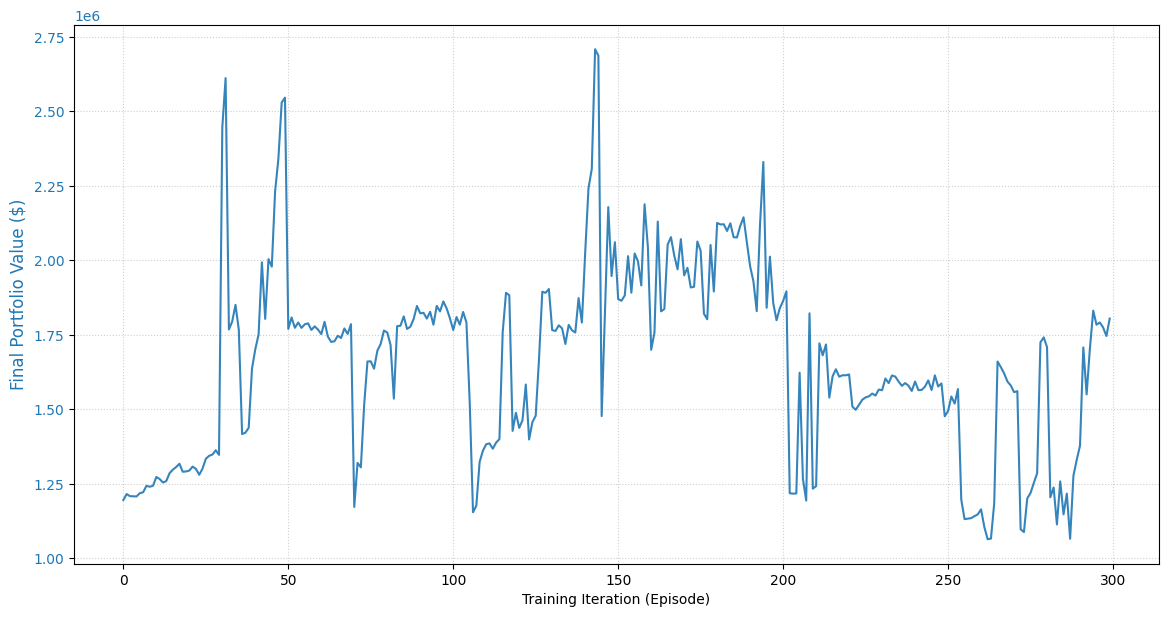

In [14]:
# --- Plot Training Results ---
print("Plotting training results...")
fig, ax1 = plt.subplots(figsize=(14, 7)) # Wider figure

# Plot 1: Portfolio Value (Left Y-axis)
color = 'tab:blue'
ax1.set_xlabel('Training Iteration (Episode)')
ax1.set_ylabel('Final Portfolio Value ($)', color=color, fontsize=12)
ax1.plot(portfolio_value_history, color=color, label='Portfolio Value', alpha=0.9, linewidth=1.5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle=':', alpha=0.6)

In [18]:
# Plot 2: Average LLC Reward per Step (Right Y-axis 1)
ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Avg LLC Reward per Step', color=color, fontsize=12)
ax2.plot(episode_rewards_history, color=color, label='Avg LLC Reward/Step', alpha=0.7, linewidth=1.5)
ax2.tick_params(axis='y', labelcolor=color)
# Optional: Add a horizontal line at 0 for LLC reward reference
# ax2.axhline(0, color=color, linestyle='--', linewidth=0.8, alpha=0.5)

In [19]:
# Plot 3: Alpha_t Decay (Right Y-axis 2)
ax3 = ax1.twinx() # instantiate a third axes that shares the same x-axis
# Offset the third axis spine to prevent overlap
ax3.spines["right"].set_position(("axes", 1.12)) # Adjust position offset as needed
color = 'tab:green'
ax3.set_ylabel('Alpha_t (HLC Reward Weight)', color=color, fontsize=12)
ax3.plot(alpha_history, color=color, label='Alpha_t', linestyle='--', alpha=0.8, linewidth=1.5)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylim(0, ALPHA_0 * 1.1) # Set Y limits for alpha plot

# --- Add Legends ---
# Combine legends from all axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
# Place legend strategically (e.g., upper center)
ax2.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)


fig.suptitle('HRT Agent Training Performance Over Iterations', fontsize=16)
fig.tight_layout(rect=[0, 0.05, 1, 0.96]) # Adjust layout to make space for title and legend
plt.show()

print("\nCell 10: Phased Training Loop completed.")


Cell 10: Phased Training Loop completed.



Starting Cell 11: Evaluation on Trading Data...
Initializing evaluation environment...
Evaluation environment initialized for 216 trading steps.
Running evaluation loop (deterministic)...

Trading Evaluation Complete.
Total Evaluation Steps: 216
Final Portfolio Value: $1,139,567.42
Plotting evaluation results...
Calculating Buy & Hold benchmark...
Buy & Hold benchmark added to plot.


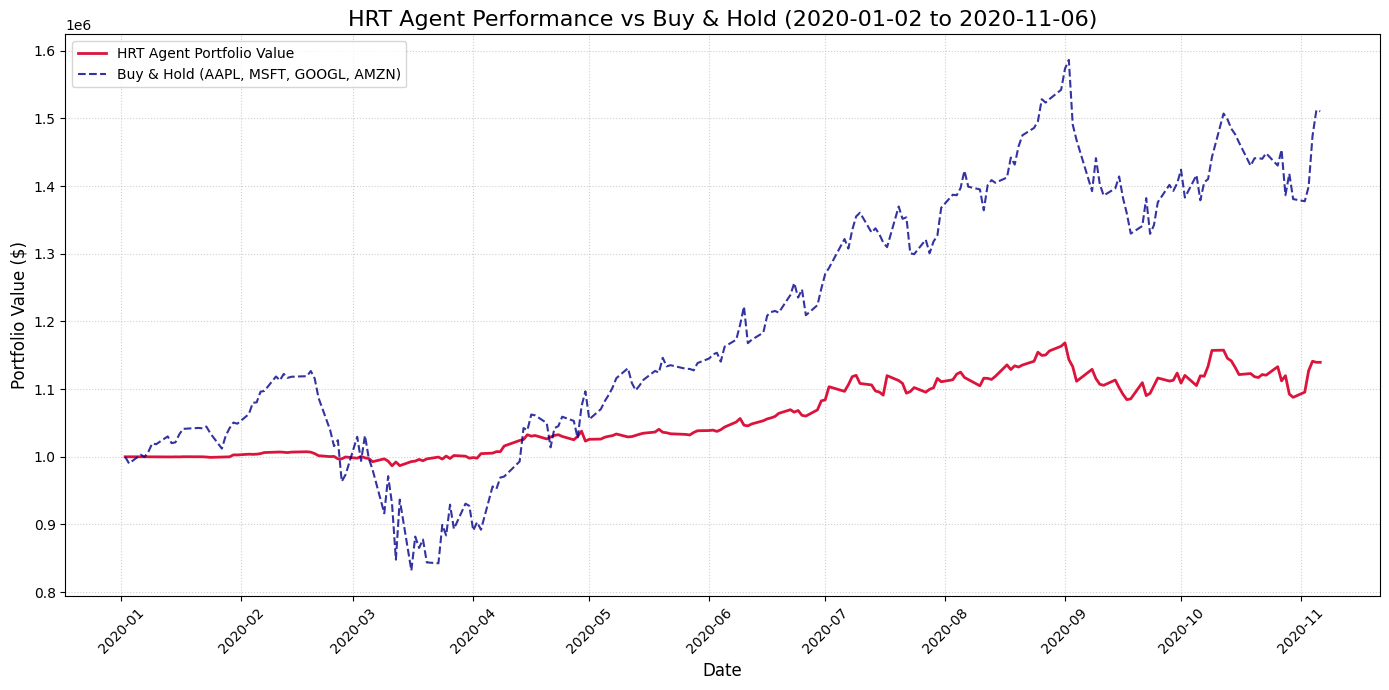


Calculating final performance metrics...

--- Performance Metrics (Evaluation Period: 2020-01-02 to 2020-11-06) ---
Final Portfolio Value: $1,139,567.42
Cumulative Return: 13.96%
Annualized Volatility: 11.29%
Annualized Sharpe Ratio: 1.4579
Maximum Drawdown: -7.18%

Cell 11: Evaluation and Visualization completed.


In [20]:
# **Cell 11: Evaluation & Visualization (Unchanged but Verified)**

# ==================== Cell 11: Evaluation & Visualization ====================
# Description: Evaluates the performance of the trained HRT agent on unseen
#              trading data. Runs the agent deterministically (no exploration noise),
#              plots the portfolio value against a benchmark, and calculates
#              key performance metrics (Cumulative Return, Sharpe Ratio, Max Drawdown).

# Necessary imports (in case running standalone)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("\nStarting Cell 11: Evaluation on Trading Data...")

# --- Ensure necessary variables from previous cells are available ---
required_eval_vars = [
    'hlc_states_trade', 'close_prices_trade', 'open_prices_trade', 'dates_trade',
    'INITIAL_BALANCE', 'TRANSACTION_COST_PCT', 'HMAX', 'NUM_STOCKS', 'HLC_STATE_FEATURES',
    'hlc_state_normalizer', 'balance_normalizer', 'price_normalizer', 'holdings_normalizer',
    'hrt_agent', # The trained agent instance from Cell 10
    'STOCK_TICKERS' # The final list of tickers used
]
for var_name in required_eval_vars:
     if var_name not in globals() or globals()[var_name] is None:
          raise NameError(f"Required variable '{var_name}' for evaluation not found or not initialized. Run previous cells.")
if hlc_states_trade.shape[0] == 0:
     raise ValueError("Trading data (hlc_states_trade) is empty. Cannot evaluate.")

# --- Initialize Trading Environment for Evaluation ---
print("Initializing evaluation environment...")
env_trade = StockTradingEnv(
    hlc_states=hlc_states_trade,
    close_prices=close_prices_trade,
    open_prices=open_prices_trade,
    dates=dates_trade,
    initial_balance=INITIAL_BALANCE,
    transaction_cost_pct=TRANSACTION_COST_PCT,
    hmax=HMAX,
    num_stocks=NUM_STOCKS,
    hlc_state_features=HLC_STATE_FEATURES,
    hlc_state_norm=hlc_state_normalizer, # Use normalizers fitted on training data
    balance_norm=balance_normalizer,
    price_norm=price_normalizer,
    holdings_norm=holdings_normalizer,
    mode='trade' # Set mode to 'trade'
)
print(f"Evaluation environment initialized for {len(dates_trade)} trading steps.")

# --- Run Evaluation Loop ---
print("Running evaluation loop (deterministic)...")
llc_state, info = env_trade.reset()
hlc_state = info['hlc_state']
terminated, truncated = False, False
evaluation_steps = 0

while not terminated and not truncated:
    # Select actions deterministically (NO exploration noise for LLC)
    hlc_action_env, _, _, _, llc_action_normalized = \
        hrt_agent.select_actions(hlc_state, llc_state, add_llc_noise=False) # Key change: No noise

    # Environment step
    next_llc_state, reward_llc, terminated, truncated, info = \
        env_trade.step(llc_action_normalized, hlc_action_env)

    # Update states for the next step
    hlc_state = info['hlc_state']
    llc_state = next_llc_state
    evaluation_steps += 1

# --- Log Final Evaluation Results ---
print("\nTrading Evaluation Complete.")
print(f"Total Evaluation Steps: {evaluation_steps}")
final_portfolio_value = env_trade.total_value # Get final value from the env instance
print(f"Final Portfolio Value: ${final_portfolio_value:,.2f}")

# --- Plot Trading Results ---
print("Plotting evaluation results...")
# Extract portfolio values and dates from the evaluation environment run
trade_portfolio_values = env_trade.portfolio_values
trade_dates = env_trade.dates

# Ensure plot data alignment (handles potential off-by-one from initial value)
if len(trade_portfolio_values) == len(trade_dates) + 1:
    trade_portfolio_plot_values = trade_portfolio_values[1:] # Exclude initial value
    trade_plot_dates = trade_dates
elif len(trade_portfolio_values) == len(trade_dates):
     trade_portfolio_plot_values = trade_portfolio_values
     trade_plot_dates = trade_dates
else:
     print(f"Warning: Length mismatch between portfolio values ({len(trade_portfolio_values)}) and dates ({len(trade_dates)}). Plotting may be inaccurate.")
     # Attempt to plot the shorter length
     min_len = min(len(trade_portfolio_values), len(trade_dates))
     trade_portfolio_plot_values = trade_portfolio_values[:min_len]
     trade_plot_dates = trade_dates[:min_len]

# Create the plot
plt.figure(figsize=(14, 7))
plt.plot(trade_plot_dates, trade_portfolio_plot_values, label='HRT Agent Portfolio Value', linewidth=2, color='crimson')

# --- Calculate and Plot Buy & Hold Benchmark ---
print("Calculating Buy & Hold benchmark...")
try:
    if NUM_STOCKS > 0 and len(close_prices_trade) > 0:
        # Initial equal allocation
        initial_investment_per_stock = INITIAL_BALANCE / NUM_STOCKS
        # Use the first day's closing price from the *trading* data
        first_day_prices = close_prices_trade[0]
        # Avoid division by zero if a price is zero
        safe_first_day_prices = np.where(first_day_prices <= 0, 1e-6, first_day_prices)
        initial_shares = initial_investment_per_stock / safe_first_day_prices

        # Calculate B&H value for each day in the trading period
        bnh_values = [np.sum(initial_shares * close_prices_trade[i]) for i in range(len(close_prices_trade))]

        # Ensure benchmark aligns with the plotted dates/values
        if len(bnh_values) == len(trade_plot_dates):
            plt.plot(trade_plot_dates, bnh_values, label=f'Buy & Hold ({", ".join(STOCK_TICKERS)})', linestyle='--', alpha=0.8, color='darkblue')
            print("Buy & Hold benchmark added to plot.")
        else:
            print(f"Warning: Buy & Hold benchmark length ({len(bnh_values)}) doesn't match plot dates length ({len(trade_plot_dates)}). Skipping benchmark plot.")
    else:
        print("Skipping Buy & Hold benchmark calculation (No stocks or trading data).")

except Exception as e:
    print(f"Could not calculate or plot Buy & Hold benchmark: {e}")

# --- Finalize Plot ---
# Use the actual start and end dates from the plot data
start_date_str = trade_plot_dates.min().strftime("%Y-%m-%d") if not trade_plot_dates.empty else "N/A"
end_date_str = trade_plot_dates.max().strftime("%Y-%m-%d") if not trade_plot_dates.empty else "N/A"
plt.title(f'HRT Agent Performance vs Buy & Hold ({start_date_str} to {end_date_str})', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Calculate Final Performance Metrics (Based on Paper Section 4.3) ---
print("\nCalculating final performance metrics...")

# Use the plotted values (which exclude initial balance) for calculations
if len(trade_portfolio_plot_values) > 1:
    returns_series = pd.Series(trade_portfolio_plot_values, index=trade_plot_dates).pct_change().dropna()

    if not returns_series.empty:
        # 1. Cumulative Return
        final_val = trade_portfolio_plot_values[-1]
        cumulative_return = (final_val / INITIAL_BALANCE) - 1

        # 2. Annualized Volatility
        daily_std_dev = returns_series.std()
        annualized_volatility = daily_std_dev * np.sqrt(252) # Assuming 252 trading days

        # 3. Annualized Sharpe Ratio (Assuming Risk-Free Rate = 0, as per paper)
        sharpe_ratio = 0.0
        if annualized_volatility != 0:
            # Use annualized return for Sharpe calculation
            num_years = len(trade_plot_dates) / 252.0
            # Handle case where num_years is very small or zero
            annualized_return = ((1 + cumulative_return)**(1 / num_years) - 1) if num_years > 0 else 0.0
            sharpe_ratio = annualized_return / annualized_volatility

        # 4. Max Drawdown
        # Calculate wealth index starting from INITIAL_BALANCE
        wealth_index = (1 + returns_series).cumprod() * INITIAL_BALANCE
        # Need to prepend the initial balance to calculate peaks correctly from start
        wealth_index_with_start = pd.concat([pd.Series([INITIAL_BALANCE], index=[trade_plot_dates[0] - pd.Timedelta(days=1)]), wealth_index])
        peak = wealth_index_with_start.expanding(min_periods=1).max()
        drawdown = (wealth_index_with_start - peak) / peak # Calculate drawdown percentage
        max_drawdown = drawdown.min() # Minimum value is the max drawdown

        print(f"\n--- Performance Metrics (Evaluation Period: {start_date_str} to {end_date_str}) ---")
        print(f"Final Portfolio Value: ${final_val:,.2f}")
        print(f"Cumulative Return: {cumulative_return:.2%}")
        print(f"Annualized Volatility: {annualized_volatility:.2%}")
        print(f"Annualized Sharpe Ratio: {sharpe_ratio:.4f}")
        print(f"Maximum Drawdown: {max_drawdown:.2%}")

    else:
        print("Cannot calculate metrics: No valid returns data available after processing.")
else:
    print("Cannot calculate metrics: Insufficient data points in evaluation results.")

print("\nCell 11: Evaluation and Visualization completed.")